Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run).

Do not remove any cell from the notebook you downloaded. You can add any number of cells (and remove them if not more necessary). 

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!!!

Fill in your name and id number (numero matricola) below:

In [ ]:
NAME = "Victor Miguel Velazquez Espitia"
ID_number = int("2043179")

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# HOMEWORK #4

## Unsupervised learning

In this notebook we are going to explore the use of unsupervised clustering methods.

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs

In [ ]:
# TODO 1: Write a function to compute the probability density function (pdf) of a gaussian random vector:
# you just need to apply its definition.

def gv_normalizing_const(sigma : np.ndarray) -> np.float64:
    '''
    Function to compute the normalization coefficient of a vector valued Gaussian distribution.
    :param sigma: Covariance of the Gaussian random vector (d x d Positive Definite matrix). 
    '''
    # YOUR CODE HERE
    d = sigma.shape[0]
    normalizing_const = 1/((2*3.1416)**(d/2)*np.linalg.det(sigma)**(1/2))    
    return normalizing_const

def gaussian_pdf(x : np.ndarray, mu : np.ndarray, sigma : np.ndarray) -> np.ndarray:
    '''
    Function to compute the pdf of a vector valued gaussian distribution on the location x given its parameters, 
    mu and sigma. We are assuming sigma is invertible (you do not need to check its invertibility). For simplicity
    return the pdf with shape (1,1), this should be the shape you get after the quadratic form computation. 
    '''
    # YOUR CODE HERE
    A = - (1/2) * (x-mu).T @ (np.linalg.inv(sigma)) @ (x-mu)
    unnormmalized_pdf = (np.e)**A#[0][0]
    
    return gv_normalizing_const(sigma) * unnormmalized_pdf

In [ ]:
assert type(gv_normalizing_const(np.array([[2.]]))) == np.float64
# Test on scalar case
x = np.array([[1.]])
mean, cov = np.array([[2.5]]), np.array([[0.5]])
assert np.isclose(multivariate_normal.pdf(1, mean=mean, cov=cov), gaussian_pdf(x, mean, cov), atol=1e-3)

# Test on vector valued case
mean, temp = np.random.normal(2, 3, 2).reshape(-1,1), np.random.normal(2, 3, 4).reshape(2,2)
x = np.random.normal(2, 3, 2).reshape(-1,1)
cov = temp @ temp.T
hand_pdf = gaussian_pdf(x, mean, cov)
scipy_pdf = multivariate_normal.pdf(x.reshape(1,-1)[0], mean.reshape(1,-1)[0], cov)
assert np.isclose(hand_pdf, scipy_pdf, atol=1e-4)


Let's load a 1-D dataset which does not contain any label. It has been generated using K clusters.

Can you tell how many clusters have been used by looking at the scatter plot?

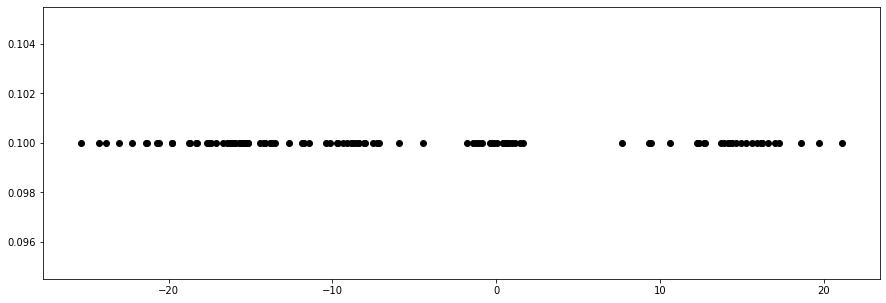

In [ ]:
url = 'https://raw.githubusercontent.com/LucaZancato/ML2020-2021/main/HW_4/1_D_dataset.csv'
data = np.array(pd.read_csv(url, sep=';'))

plt.figure(figsize=(15,5))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color='k')

It's not trivial to understand how many clusters are present. Such an issue is present also in the case of Expectation-Maximization (EM) on Gaussian Mixture Models (GMM) (the one we are going to implement) and K-means: for both of these algorithms the number of clusters is fixed a priori, it is a parameter (hyper-parameter) we must decide before processing any data.

Usually, in order to achieve satisfactory clustering, one needs to try with different number of classes and validate which is the best number. 

For now let's make it simple and let's consider the dataset has 3 clusters.

In the following cell we shall parametrize 3 Gaussian random variables specifiying both means, covariances and mixing probabilities. Take a moment to understand the way these parameters are stored, since the EM implementation is built on this notation. For now, means, cov and mixing probabilities are choosen without any specific criteria: we will see how EM applied to GMM will provide us a suboptimal set of means, covariances and mixing probabilities.

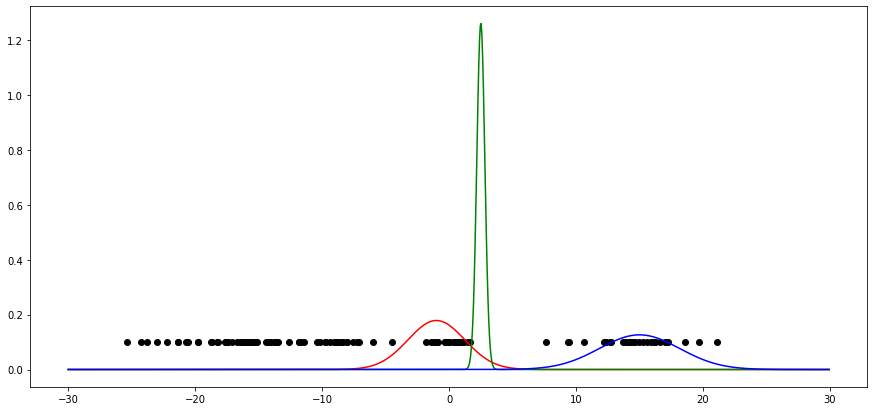

In [ ]:
means = np.array([[-1],[2.5],[15]])      # shape (K,d)
covs  = np.array([[[5]],[[0.1]],[[10]]]) # shape (K,d,d) 
pi    = np.array([1/2, 1/4, 1/4])        # shape (K,)

X = np.linspace(-30, 30, 1000, endpoint=False).reshape(-1,1)

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color='k')
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

In [ ]:
# TODO 2: Write a function M_step which computes the M-step of the EM algorithm under a GMM. Refer 
# to the slides you can find on moodle (in which ALL the necessary steps and expressions are present).
# Start by looking at the function "M_step" and then build all the helper functions.

def update_pi(W : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    new_pi = np.zeros((W.shape[1],))
    for k in range(W.shape[1]):
      new_pi[k] = np.sum(W[:,k])/W.shape[0]
 
    return new_pi

def update_means(data : np.ndarray, W : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE
    new_means = np.matmul(np.transpose(W),data)
    for k in range(W.shape[1]):
        new_means[k,:] = new_means[k,:]/np.sum(W[:,k])
    return new_means

def update_covs(data : np.ndarray, W : np.ndarray, new_means : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE
    new_covs = np.zeros((W.shape[1],data.shape[1],data.shape[1])) #k x (d x d)

    for k in range(W.shape[1]):
        temp = np.zeros((data.shape[1],data.shape[1]))
        for n in range(data.shape[0]):
            dif_x_mu= data[n]-new_means[k]
            temp = temp + np.outer(dif_x_mu,dif_x_mu)*W[n][k]
        new_covs[k] = temp/np.sum(W[:,k])    
    return new_covs

def M_step(data : np.ndarray, W : np.ndarray) -> tuple:
    '''
    Function to compute the Maximization step on a GMM (use the expressions derived on the slides).
    :param data: Dataset N x d (d := number of features)
    :param W: Weight matrix N x K (K :=number of classes). Element in position (i,j) represents the probability of
              i-th datum to belong to class j (j-th cluster) given the current parameters: pi, means, covs
    :returns: (new_pi, new_mu, new_cov)
        WHERE:
        new_pi: Contains the mixing probabilities. Its shape is (K,)
        new_mu: Contains the new means of the GMM model. Its shape is (K, d)
        new_cov: Contains the new covariances of the GMM model. Its shape is (K, d, d)
    '''
    new_pi    = update_pi(W)
    new_means = update_means(data, W)
    new_covs  = update_covs(data, W, new_means)
    
    return new_pi, new_means, new_covs 

In [ ]:
W = np.array([[0.5, 0.5, 0],[0.5, 0, 0.5]])
assert np.isclose(update_pi(W), [0.5 , 0.25, 0.25], atol=1e-4).all()
W = np.random.normal(0,1, 1000).reshape(-1, 25) # Note this W is not normalized properly, we do not care not since we are testing only the output shape is correct
assert update_pi(W).shape == (25,)
# Test on the means update function
a = np.random.normal(0,1, 80).reshape(-1, 2)
b = update_means(a, W)
assert b.shape  == (25, 2)
# Test on the covs update function
assert update_covs(a, W, b).shape == (25, 2, 2)


In [ ]:
# TODO 3: Write a function E_step which computes the E-step of the EM algorithm in case of a GMM. Refer 
# to the slides you can find on the moodle (in which ALL the necessary steps and expressions are present).
def E_step(data : np.ndarray, pi : np.ndarray, means : np.ndarray, covs : np.ndarray):
    '''
    Function to compute the Expectation step on a GMM model (use the expressions derived on the slides) given 
    the current values of the GMM parameters: pi, means, covs.
    :param data:  Same as M_step function.
    :param pi:    Same as M_step function.
    :param means: Same as M_step function.
    :param covs:  Same as M_step function.
    :returns: W, which is updated using the parameters of the GMM: pi, means, covs. W must be normalized (see 
              slides)
    '''
    # YOUR CODE HERE
    W = np.zeros((data.shape[0],pi.shape[0]))
    den = 0
    for n in range(data.shape[0]):
        for k in range(pi.shape[0]):
            W[n,k] = pi[k]*gaussian_pdf(data[n], means[k], covs[k])
            den = den + W[n,k]
        W[n] = W[n]/den
        den = 0    
        
    return W

In [ ]:
assert E_step(data, pi, means, covs).shape == (119, 3)
assert np.isclose(np.sum(E_step(data, pi, means, covs).sum(1) - 1), 0, atol=1e-4)

In [ ]:
# TODO 4: Write a function to randomly initialize the parameters of a GMM. This is necessary to start with the 
# EM iterations. 

def randomly_initialize_W(data : np.ndarray, num_classes : int) -> np.ndarray:
    '''
    See random_init function docs.
    '''
    # YOUR CODE HERE
    W = np.zeros((data.shape[0],num_classes))
    i = 0
    if not (data.shape[0] % num_classes):
        for n in range (data.shape[0]):
            if i < num_classes:
                W[n][i] = 1
                i=i+1
            else:
                i = 0
                W[n][i] = 1
                i=i+1
        return np.random.permutation(W)
    else:
        n=0
        i=0
        while (n < data.shape[0]-(data.shape[0] % num_classes)):
            if i < num_classes:
                W[n][i] = 1
                i=i+1
            else:
                i = 0
                W[n][i] = 1                
                i=i+1 
            n = n+1

        rand_class = np.random.randint(0, num_classes-1)
        for j in range(n,data.shape[0]):
            W[j][rand_class] = 1
        return np.random.permutation(W)
    return W

def random_init(data : np.ndarray, num_classes : int) -> np.ndarray:
    '''
    Function to initialize W and GMM parameters. W is generated assigning randomly each datapoint only to one 
    cluster. We require to assign the same number of points for each cluster (even this is not striclty necessary
    to run the EM algorithm on GMM). If the number of data is not exactly divisible by the number of clusters 
    assign the exceeding data to one single class (it does not matter which one). 
    See M_step docs for details on W, interpretation and required shape.
    '''
    # Initialize W
    W = randomly_initialize_W(data, num_classes)
    # Use M_step to get GMM parameters
    pi, means, covs = M_step(data, W)
    return W, pi, means, covs

In [ ]:
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,10), 5).sum(0) == 2).all()
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,5), 2).sum(0) == 10).all()
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,5), 3).sum(0) -6 == 2).any()

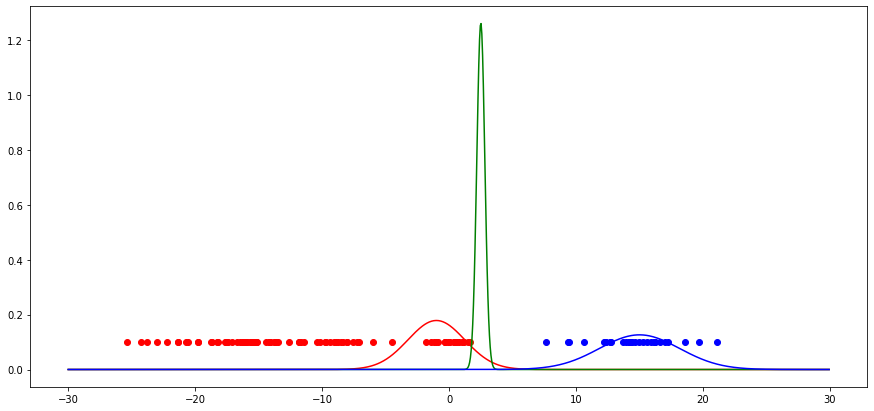

In [ ]:
# Let's evaluate the class probability of each datum given current pi, means and covs. 
# Since we have 3 clusters we shall colour-code (rgb) each datum according to the class probabilities. Note that 
# it is not very likely to have a datum coming from the central (very peaked) distribution. 
W = E_step(data, pi, means, covs)

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color=np.array([W[i][0], W[i][1], W[i][2]]))
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

In [ ]:
# TODO 5: compute the log likelihood of an iid dataset under a GMM model.
def log_likelihood_GMM(data : np.ndarray, pi : np.ndarray, means : np.ndarray, covs : np.ndarray) -> float:
    '''
    Function to compute the log likelihood for a set of iid observations under a GMM. Use the function you built
    before "gaussian_pdf" to compute the likelihood. 
    :param data: N x d matrix containing a set of N iid data of dimension d
    :param pi:    Same as M_step function.
    :param means: Same as M_step function.
    :param covs:  Same as M_step function.
    '''
    # YOUR CODE HERE
    sum_k, log_sum = 0, 0
    for n in range(data.shape[0]):
        for k in range(pi.shape[0]):
            sum_k = sum_k + pi[k]*gaussian_pdf(data[n], means[k], covs[k])
        log_sum = log_sum + np.log(sum_k)  #borramos el indexado a zero
    log_likelihood = log_sum
    return log_likelihood

In [ ]:
print(type(log_likelihood_GMM(data, pi, means, covs)))
assert type(log_likelihood_GMM(data, pi, means, covs)) == np.float64

<class 'numpy.float64'>


Iteration 0, log likelihood -48.0705,  delta log likelihood 0.2106
Iteration 1, log likelihood -47.5152,  delta log likelihood 0.5553
Iteration 2, log likelihood -45.9446,  delta log likelihood 1.5706
Iteration 3, log likelihood -41.9354,  delta log likelihood 4.0093
Iteration 4, log likelihood -34.8946,  delta log likelihood 7.0407
Iteration 5, log likelihood -27.5002,  delta log likelihood 7.3944
Iteration 6, log likelihood -21.0978,  delta log likelihood 6.4025
Iteration 7, log likelihood -16.3857,  delta log likelihood 4.7120
Iteration 8, log likelihood -13.6550,  delta log likelihood 2.7308
Iteration 9, log likelihood -12.1249,  delta log likelihood 1.5301
Iteration 10, log likelihood -11.0859,  delta log likelihood 1.0390
Iteration 11, log likelihood -10.2266,  delta log likelihood 0.8593
Iteration 12, log likelihood -9.4381,  delta log likelihood 0.7885
Iteration 13, log likelihood -8.6846,  delta log likelihood 0.7535
Iteration 14, log likelihood -7.9561,  delta log likelihood 

Text(0, 0.5, 'Log likelihood')

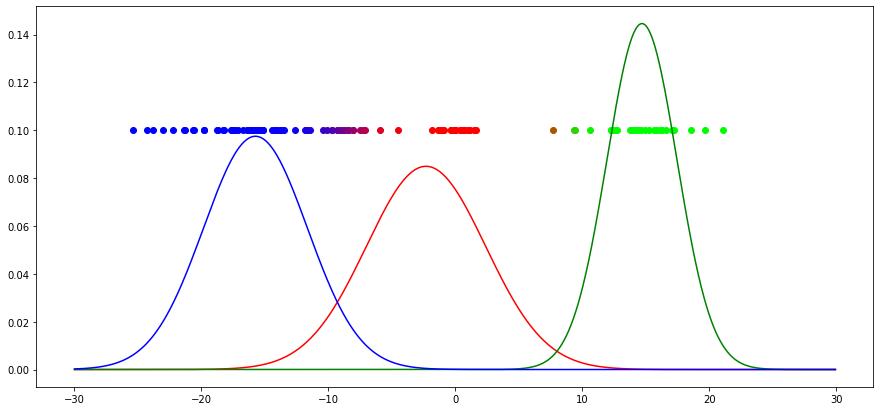

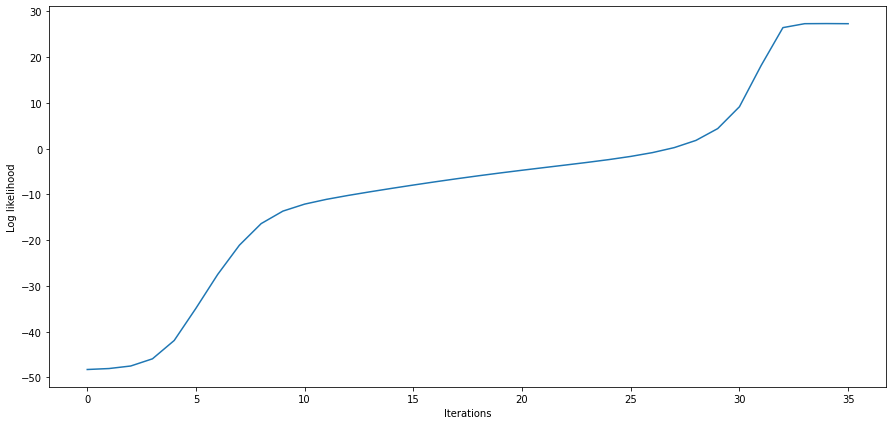

In [ ]:
# TODO 6: Write a function to run the EM on GMM using the building blocks we created so far. Then test it on the 
# data we used so far (choose a meaningful max_iter, you do not need to exaggerate). 
def run_EM_on_GMM(data : np.ndarray, number_clusters : int, max_iter : int, epsilon : float = 1e-3,
                  plot_intermediate : bool = False) -> tuple:
    '''
    Function to run GMM on a given dataset and a given number of clusters. The termination conditions of the 
    iterative algorithm take into account either a specified max number of iterations or the improvement of the 
    log likelihood (if the log likelihood does not improve more than epsilon in two successive iterations we stop).
    :param data: N x d matrix containing a set of N iid data of dimension d
    :param number_clusters: # of clusters (information we have a priori, before starting the EM)
    :param max_iter: Maximum number of iterations allowed to the EM.
    :param epsilon: Threshold on the improvement of the log likelihood
    :param plot_intermediate: Boolean used to plot intermediate GMM for 2-d datasets (you do not need to implement
                              anything).
    :returns: (W, pi, means, covs, log_likelihood_train)
        WHERE:
        W:     Optimal W     after EM reaches termination condition (same shape as M_step function).
        pi:    Optimal pi    after EM reaches termination condition (same shape as M_step function).
        means: Optimal means after EM reaches termination condition (same shape as M_step function).
        covs:  Optimal covs  after EM reaches termination condition (same shape as M_step function).
        log_likelihood_train: log likelihoods obtained during training (saved using a list). 
    '''
    W, pi, means, covs = random_init(data, number_clusters)
    log_likelihood_train = [log_likelihood_GMM(data, pi, means, covs)]
    num_iter = 0
    # Used to plot 2-d data
    if plot_intermediate:
        x_max = np.max(np.abs(X))
        x, y = np.mgrid[-x_max:x_max:.05, -x_max:x_max:.05]
        pos = np.dstack((x, y))
    
    while (True): 
        # Iterate with E-Step and M-step
        # YOUR CODE HERE
        W = E_step(data, pi, means, covs)
        pi, means, covs = M_step(data, W)        
        # Save log likelihood given current GMM parameters
        log_likelihood_train.append(log_likelihood_GMM(data, pi, means, covs)) 

        if plot_intermediate:
            # Plot scatter plot of training data and corresponding clusters    
            fig = plt.figure(figsize=(15,7))
            for k in range(0, number_clusters):
                plt.contour(x, y, multivariate_normal(means[k], covs[k]).pdf(pos))
            plt.scatter(data[0:,0], data[0:,1])
            plt.title(f'Iteration {num_iter}')
            
        print(f'Iteration {num_iter}, log likelihood {log_likelihood_train[-1]:.4f}, ' 
              f' delta log likelihood {(log_likelihood_train[-1] - log_likelihood_train[-2]):.4f}')
        num_iter += 1 
        
        # Use proper termination conditions, on: number of iteration or threshold on log likelihood improvement 
        # (use the break statement to stop while cycle)
        # YOUR CODE HERE
        if num_iter > max_iter or (log_likelihood_train[-1] - log_likelihood_train[-2] < epsilon):
            break        
    return W, pi, means, covs, log_likelihood_train

# Let's try our implementation of the EM algorithm
max_iter = 100  # to be overwritten
# YOUR CODE HERE
W, pi, means, covs, log_likelihood_train = run_EM_on_GMM(data, 3, max_iter, plot_intermediate=False)

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color=np.array([W[i][0], W[i][1], W[i][2]]))
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

plt.figure(figsize=(15,7))
plt.plot(log_likelihood_train)
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

In [ ]:
a, b, c, d, e = run_EM_on_GMM(data, 3, 10, plot_intermediate=False)
assert a.shape == (119, 3)
assert b.shape == (3,)
assert c.shape == (3, 1)
assert d.shape == (3, 1, 1)

Iteration 0, log likelihood -48.2930,  delta log likelihood 0.3161
Iteration 1, log likelihood -48.2073,  delta log likelihood 0.0857
Iteration 2, log likelihood -48.1089,  delta log likelihood 0.0984
Iteration 3, log likelihood -47.8749,  delta log likelihood 0.2340
Iteration 4, log likelihood -47.2347,  delta log likelihood 0.6402
Iteration 5, log likelihood -45.4485,  delta log likelihood 1.7862
Iteration 6, log likelihood -41.0237,  delta log likelihood 4.4249
Iteration 7, log likelihood -33.7933,  delta log likelihood 7.2304
Iteration 8, log likelihood -26.6656,  delta log likelihood 7.1277
Iteration 9, log likelihood -20.6985,  delta log likelihood 5.9671
Iteration 10, log likelihood -16.5214,  delta log likelihood 4.1771


We shall now try the same procedure with a 2-dimensional dataset.

Everything is the same as before but we can apprecaite a better visualization.

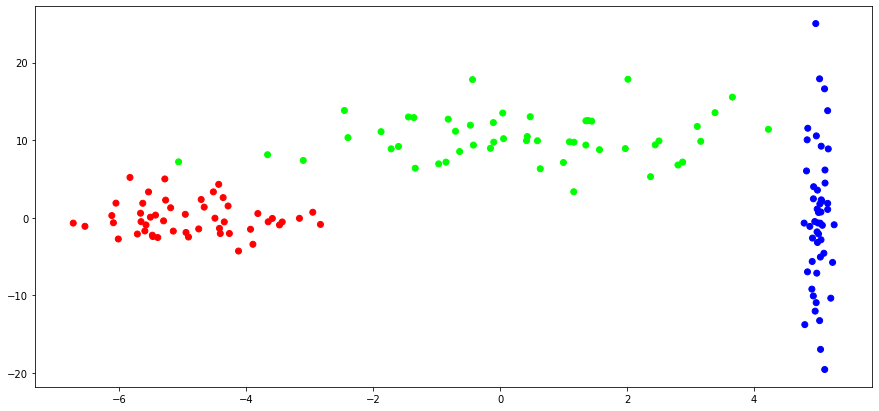

In [ ]:
# Build the 2-D dataset.
K = 3
clusters_cov = [[1,2], [2,3], [0.1,10]]
centers = [[-5, 0], [0, 10.5], [5, -1]]
X, Y = make_blobs(cluster_std=clusters_cov, centers=centers, random_state=ID_number, n_samples=150, shuffle=True)

colormap = np.array(['red', 'lime', 'blue'])

plt.figure(figsize=(15,7))
plt.scatter(X[:,0], X[:,1], c = colormap[Y])

Iteration 0, log likelihood -306.1877,  delta log likelihood 0.4291
Iteration 1, log likelihood -304.9054,  delta log likelihood 1.2823
Iteration 2, log likelihood -301.2521,  delta log likelihood 3.6533
Iteration 3, log likelihood -293.3725,  delta log likelihood 7.8796
Iteration 4, log likelihood -277.8582,  delta log likelihood 15.5143
Iteration 5, log likelihood -253.5944,  delta log likelihood 24.2639
Iteration 6, log likelihood -230.8045,  delta log likelihood 22.7899
Iteration 7, log likelihood -212.5152,  delta log likelihood 18.2893
Iteration 8, log likelihood -189.3246,  delta log likelihood 23.1906
Iteration 9, log likelihood -151.9555,  delta log likelihood 37.3692
Iteration 10, log likelihood -67.3704,  delta log likelihood 84.5851
Iteration 11, log likelihood -33.2161,  delta log likelihood 34.1542
Iteration 12, log likelihood -29.4337,  delta log likelihood 3.7825
Iteration 13, log likelihood -24.7791,  delta log likelihood 4.6546
Iteration 14, log likelihood -20.3647,  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Iteration 20, log likelihood -17.3220,  delta log likelihood 0.0316
Iteration 21, log likelihood -17.3031,  delta log likelihood 0.0189
Iteration 22, log likelihood -17.2918,  delta log likelihood 0.0113
Iteration 23, log likelihood -17.2850,  delta log likelihood 0.0068
Iteration 24, log likelihood -17.2808,  delta log likelihood 0.0041
Iteration 25, log likelihood -17.2783,  delta log likelihood 0.0025
Iteration 26, log likelihood -17.2768,  delta log likelihood 0.0015
Iteration 27, log likelihood -17.2759,  delta log likelihood 0.0009


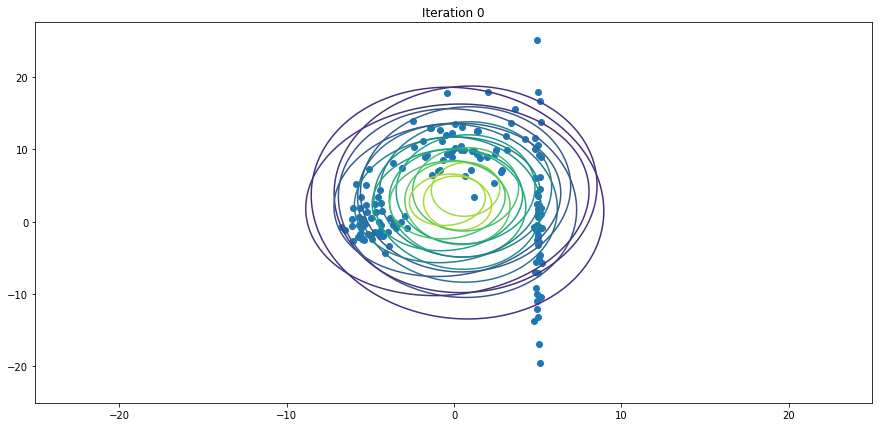

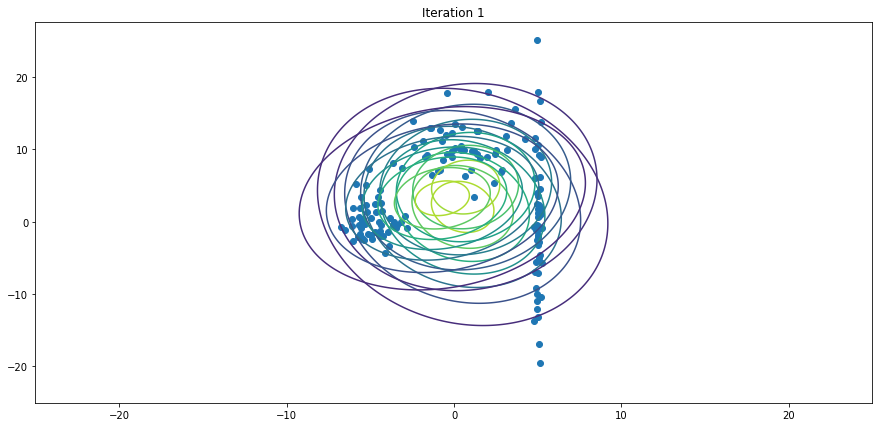

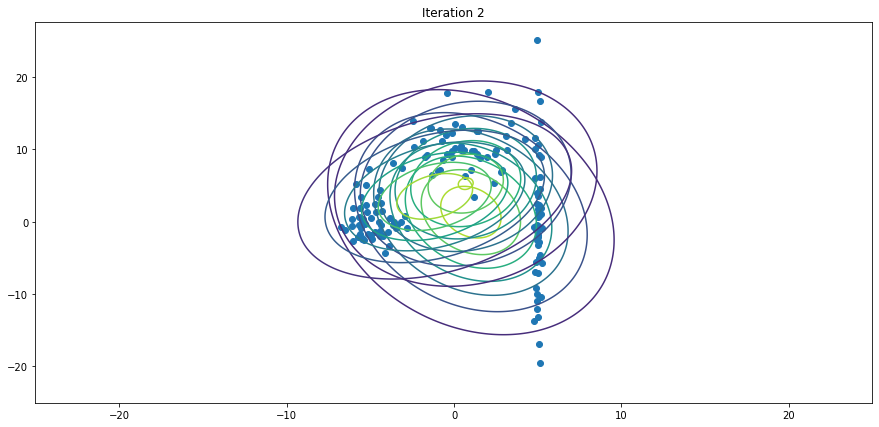

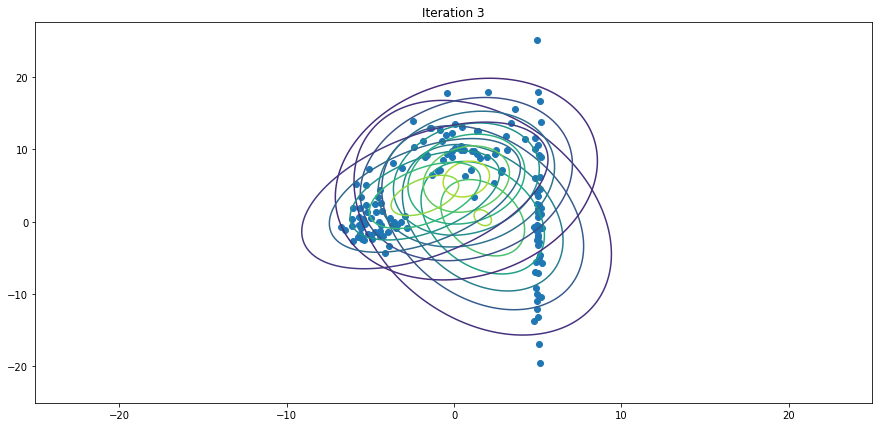

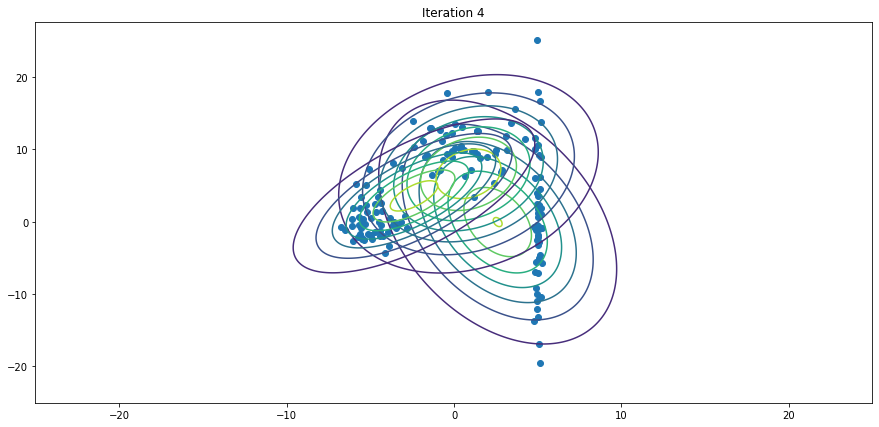

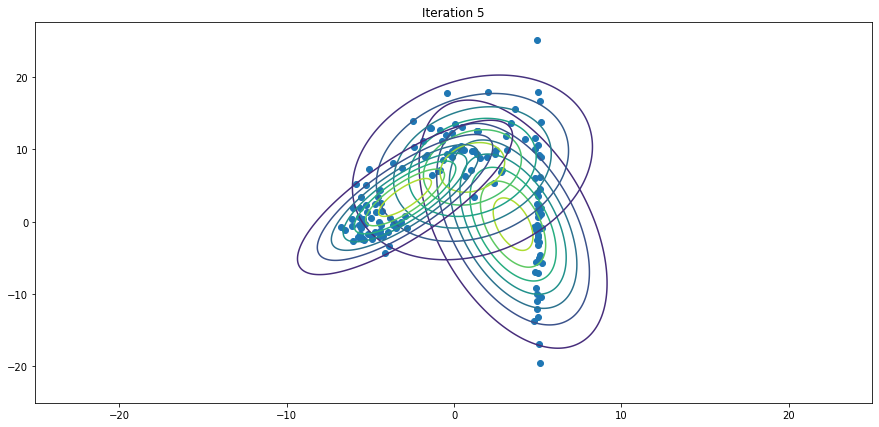

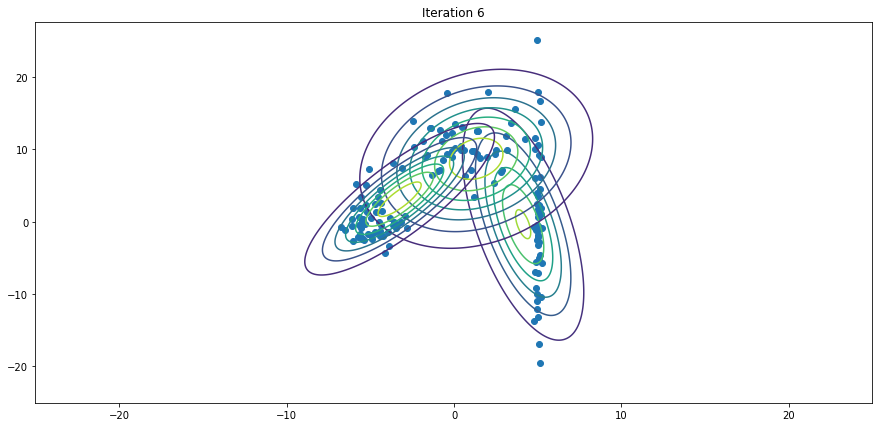

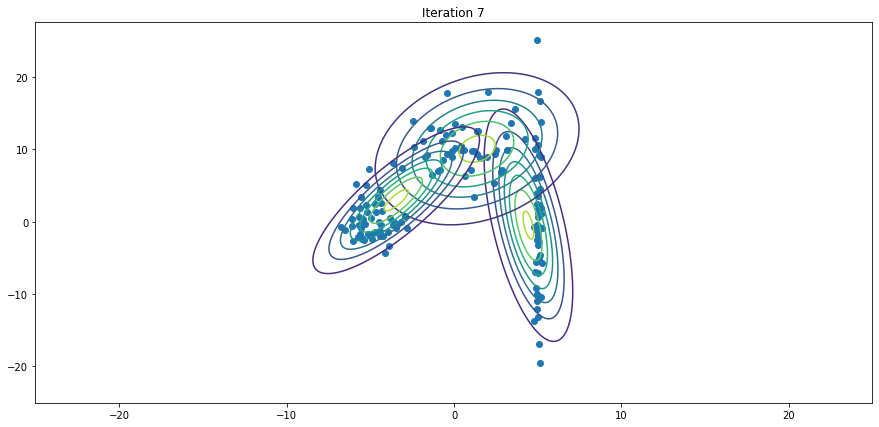

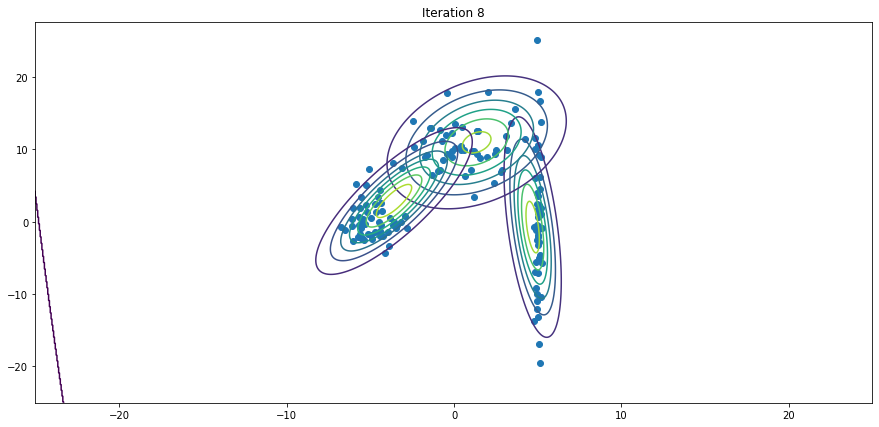

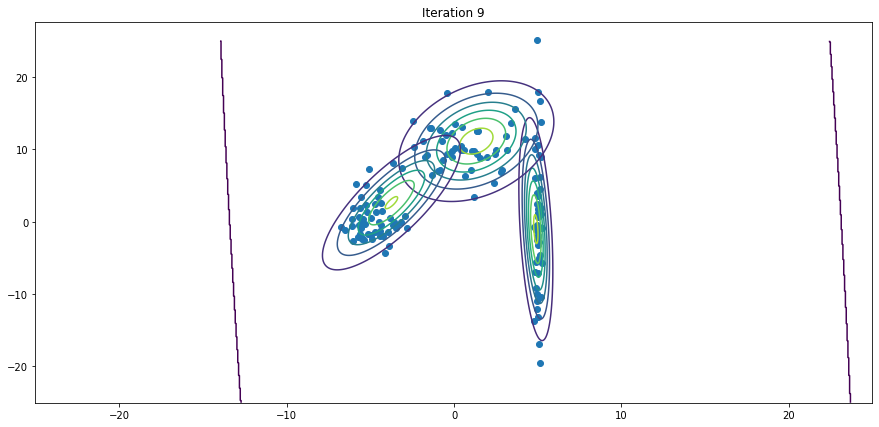

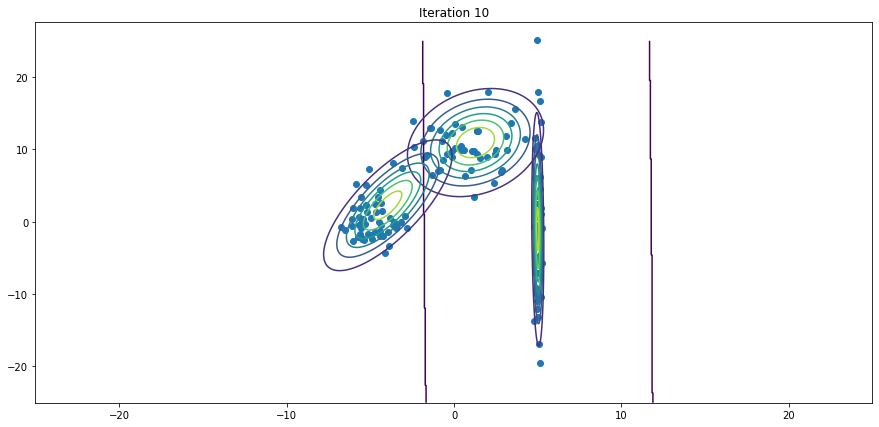

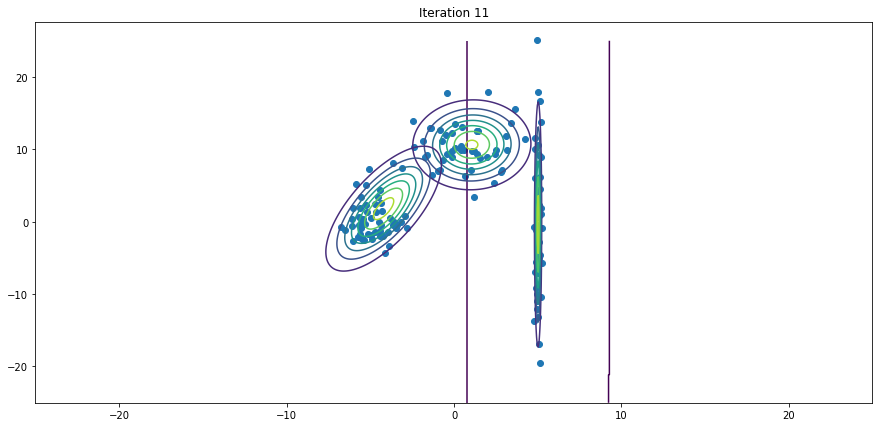

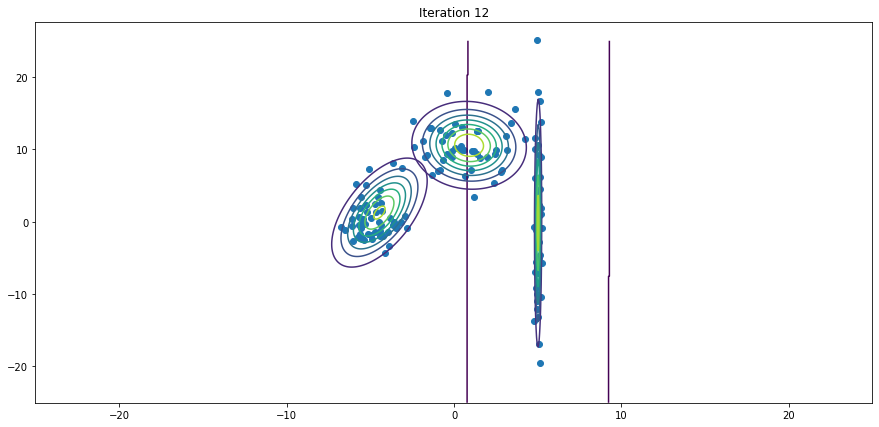

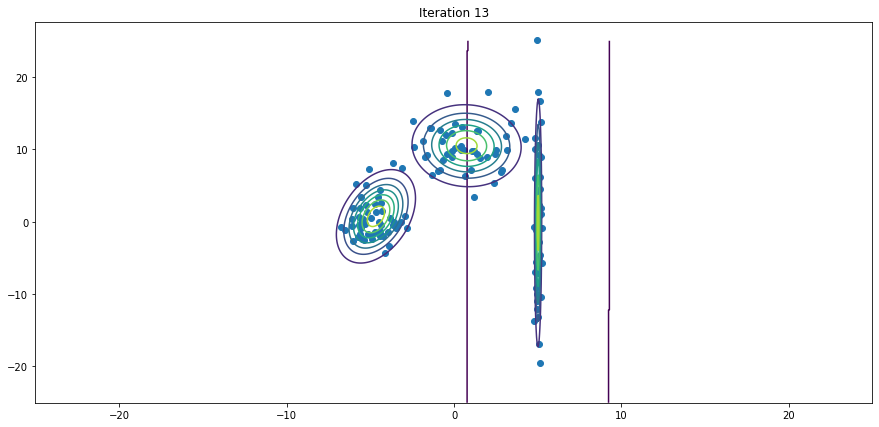

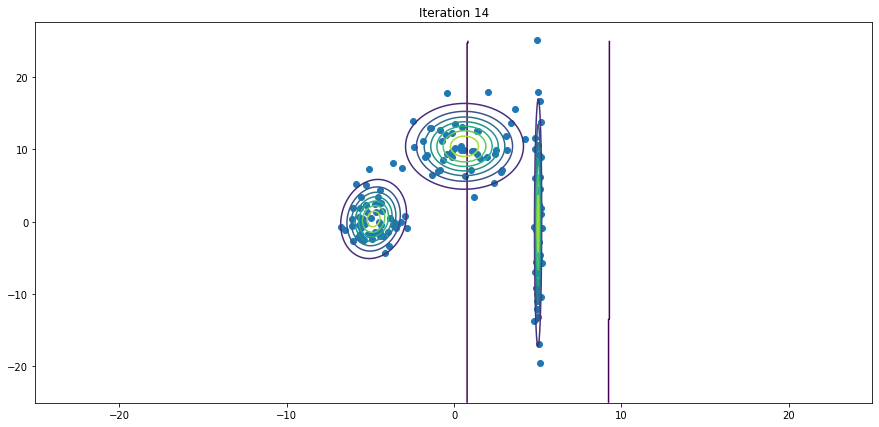

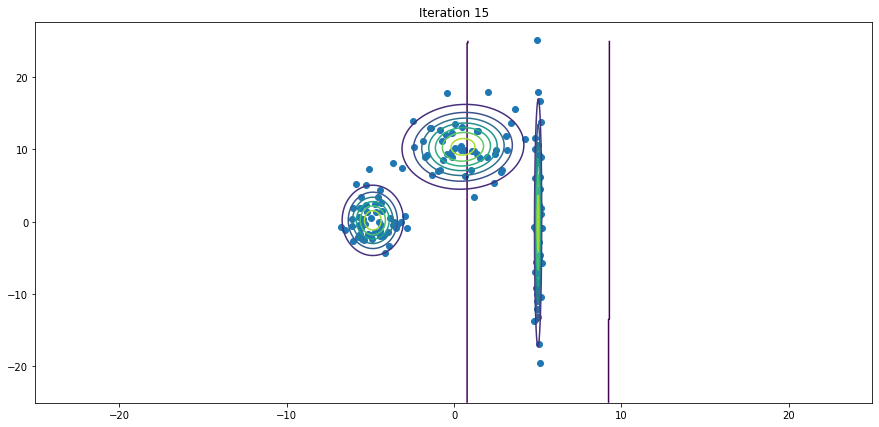

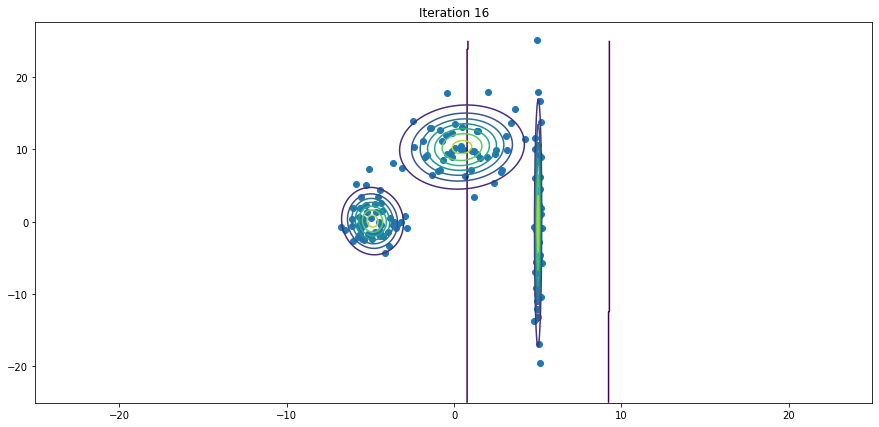

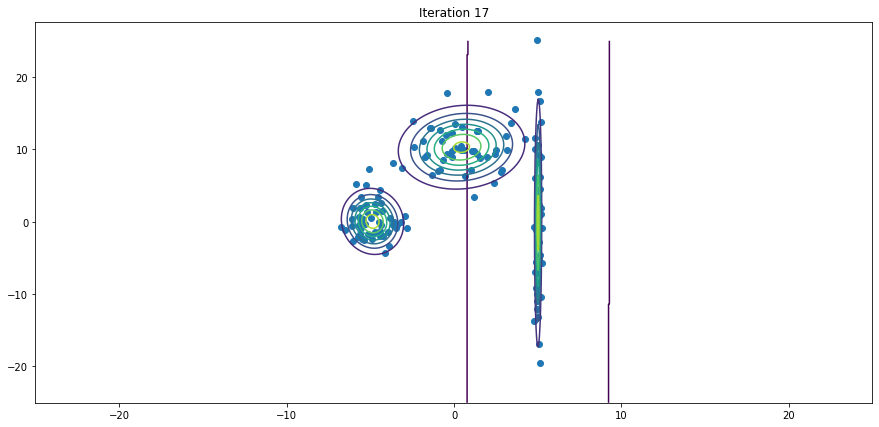

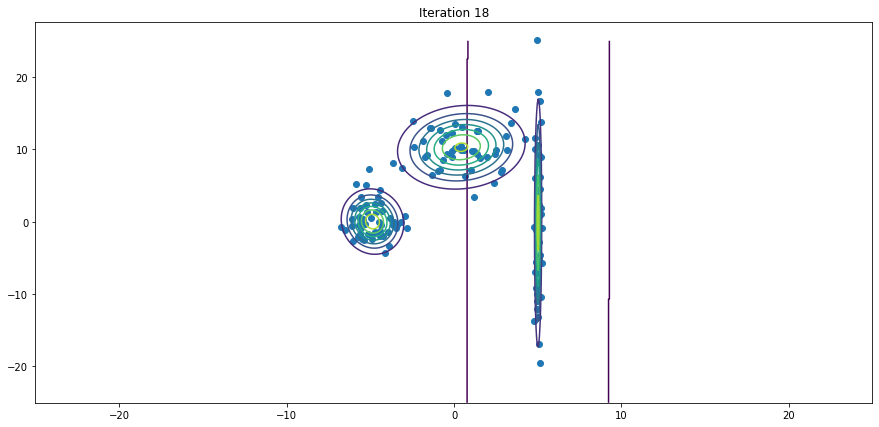

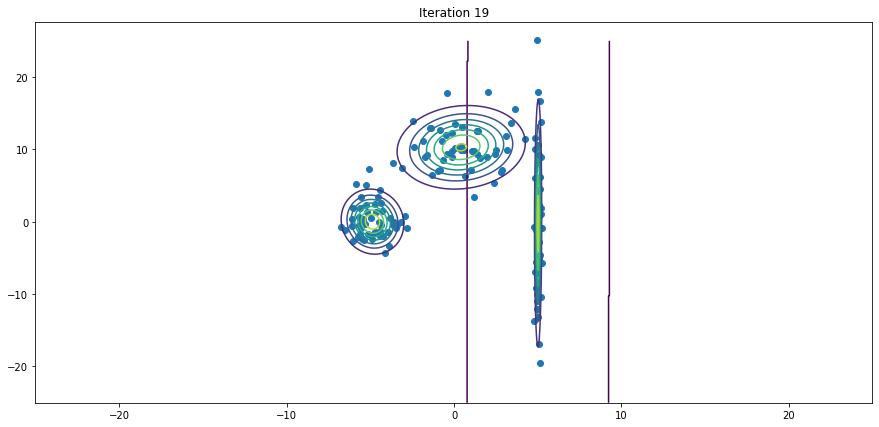

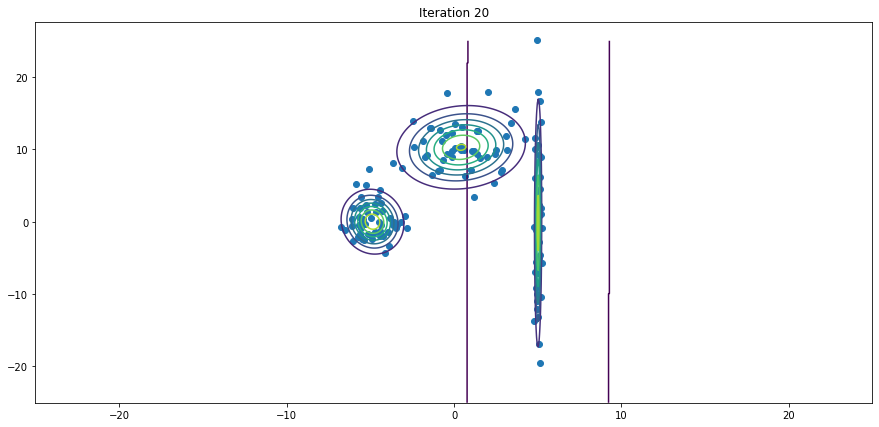

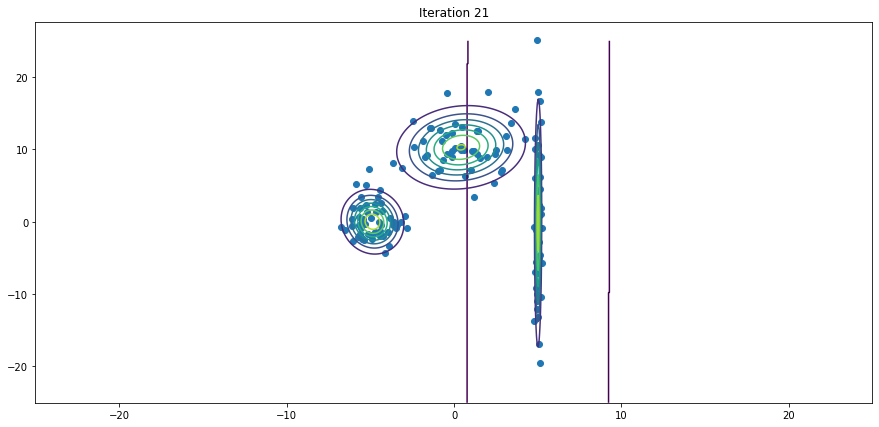

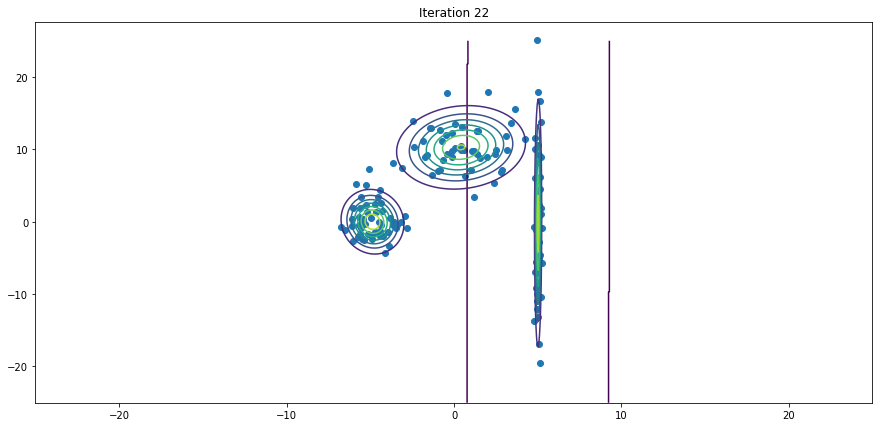

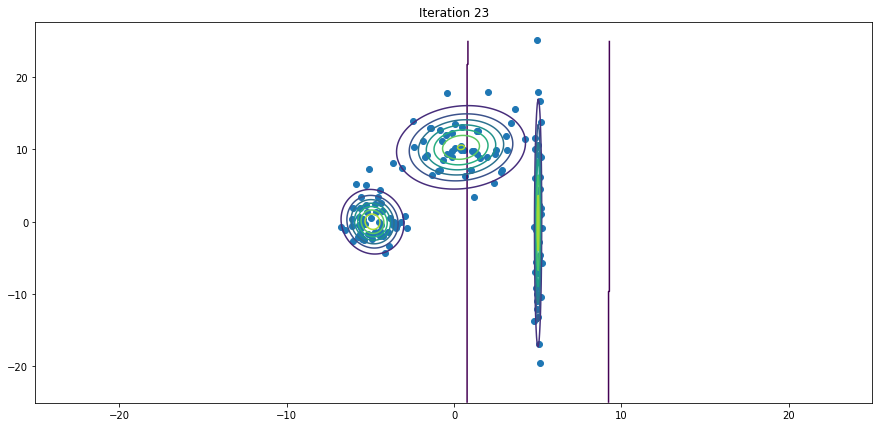

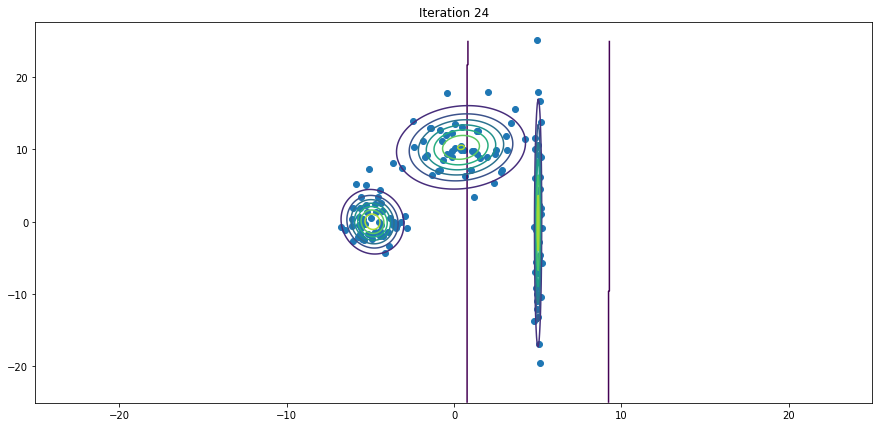

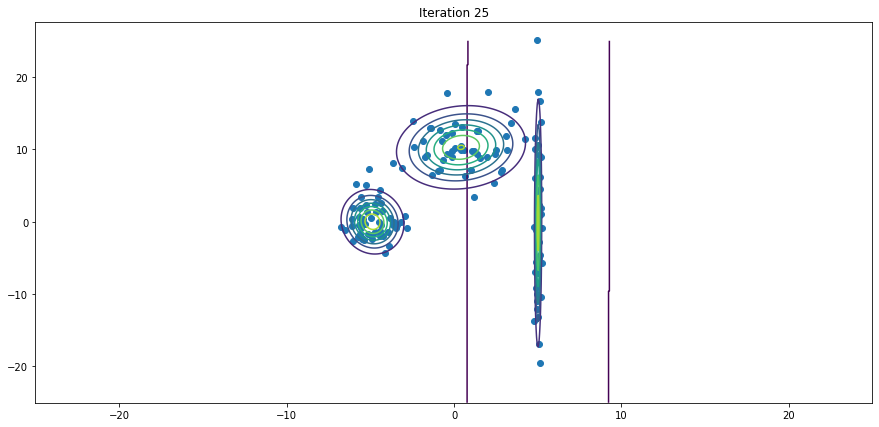

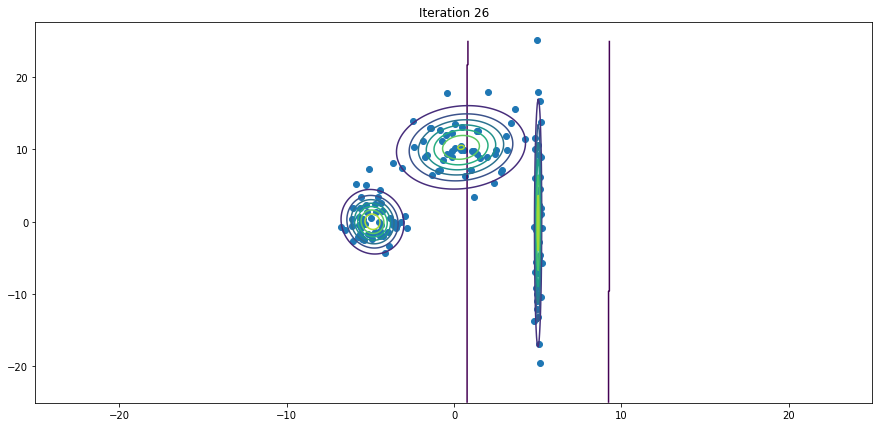

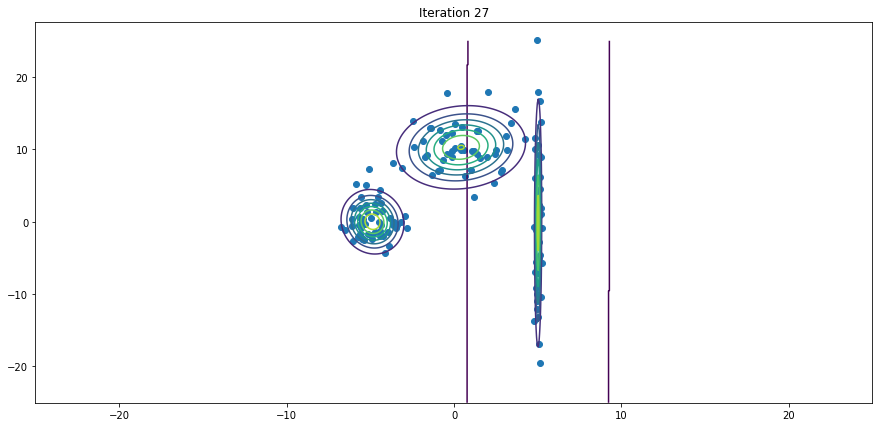

In [ ]:
# Depending on your implementation this cell might take a while to run... (this is mainly due to the plots)
W, pi, means, covs, log_likelihood_train = run_EM_on_GMM(X, K, 150, plot_intermediate=True)

Text(0, 0.5, 'Log likelihood')

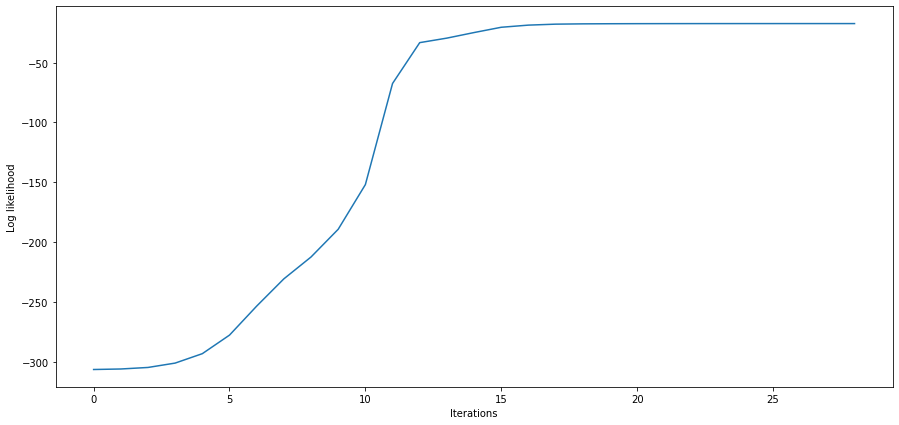

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(log_likelihood_train)
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

## TODO 7: explain the results you got (max 10 lines)

1-D dataset:
- Compare plots in to do 4 with the ones in to do 6, what has changed? Is EM providing us a meaningful clustering? 

2-D dataset:
- Why is the log likelihood monotonically increasing? Is this what you expect from the theory? Compare both log likelihood trajectory and 2-d plots.
- Is delta log likelihood monotonically going to zero?  
- Which termination criterion is met first?

(Answer in the next cell, no need to add code)

In [ ]:
# YOUR CODE HERE
"""
1-D 
    In this step EM-steps was implemented only by means of probabilities. This outputed not smooth gaussians. while in todo 6 both E and EM-steps were
    computed which for each gaussian maximizes the likelihood of probabilities that each sample get to the proper gaussian.

2-D
    In contrast with 1-D, where the initial conditions of covs,means, and pi were set. In 2-D we are looking to find the 3 variables, this is translated
    to an increasing log-likelyhood in each iteration. By the behaviour of the graph is evident to remark the elbow behaviour. Which is expected from the theory

    Following the natural behaviour likelihood tends to its maximum that cant be improved and the delta likelihood decreases monotonically to zero.
    From the results, we can conclude that the delta likelihood was the termination criterion reaching zero before the maximum. 



"""

'\n1-D \n    In this step EM-steps was implemented only by means of probabilities. This outputed not smooth gaussians. while in todo 6 both E and EM-steps were\n    computed which for each gaussian maximizes the likelihood of probabilities that each sample get to the proper gaussian.\n\n2-D\n    In contrast with 1-D, where the initial conditions of covs,means, and pi were set. In 2-D we are looking to find the 3 variables, this is translated\n    to an increasing log-likelyhood in each iteration. By the behaviour of the graph is evident to remark the elbow behaviour. Which is expected from the theory\n\n    Following the natural behaviour likelihood tends to its maximum that cant be improved and the delta likelihood decreases monotonically to zero.\n    From the results, we can conclude that the delta likelihood was the termination criterion reaching zero before the maximum. \n\n\n\n'

In [ ]:
# What is the effect of choosing a different number of classes?
centers = [[-2, 0], [0, 3], [2, -1]]
X, Y = make_blobs(cluster_std=clusters_cov, centers=centers, random_state=20, n_samples=150, shuffle=True)

Ks = [2, 3, 4, 5, 6]
results = []
for k in Ks:
    results.append(run_EM_on_GMM(X, k, 150, plot_intermediate=False))

Iteration 0, log likelihood -156.6228,  delta log likelihood 2.4336
Iteration 1, log likelihood -150.5416,  delta log likelihood 6.0812
Iteration 2, log likelihood -142.5927,  delta log likelihood 7.9489
Iteration 3, log likelihood -133.9772,  delta log likelihood 8.6155
Iteration 4, log likelihood -123.3093,  delta log likelihood 10.6679
Iteration 5, log likelihood -108.9181,  delta log likelihood 14.3912
Iteration 6, log likelihood -93.4979,  delta log likelihood 15.4202
Iteration 7, log likelihood -81.9805,  delta log likelihood 11.5174
Iteration 8, log likelihood -71.6307,  delta log likelihood 10.3498
Iteration 9, log likelihood -50.9298,  delta log likelihood 20.7009
Iteration 10, log likelihood -23.1983,  delta log likelihood 27.7315
Iteration 11, log likelihood -1.0919,  delta log likelihood 22.1064
Iteration 12, log likelihood 6.6578,  delta log likelihood 7.7497
Iteration 13, log likelihood 9.2182,  delta log likelihood 2.5604
Iteration 14, log likelihood 9.7836,  delta log l

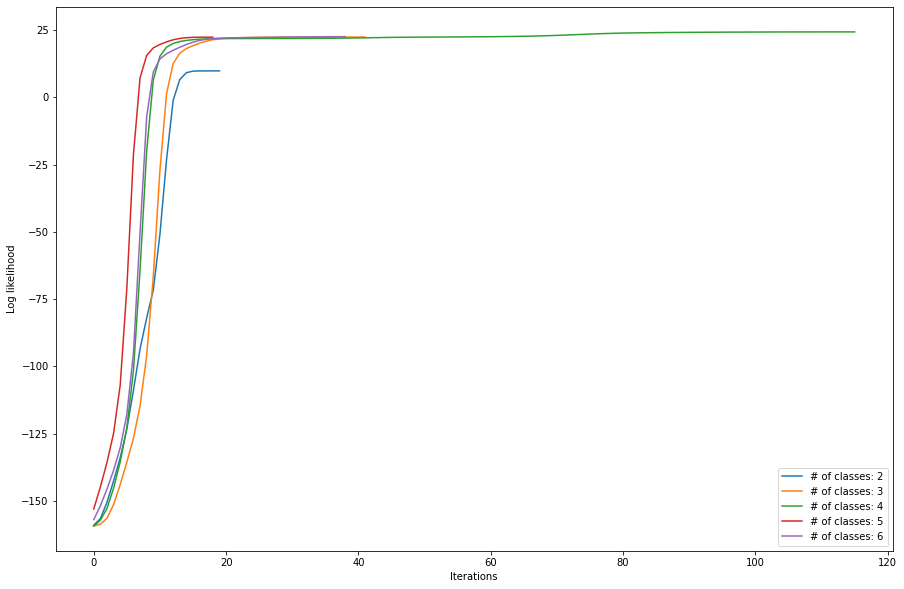

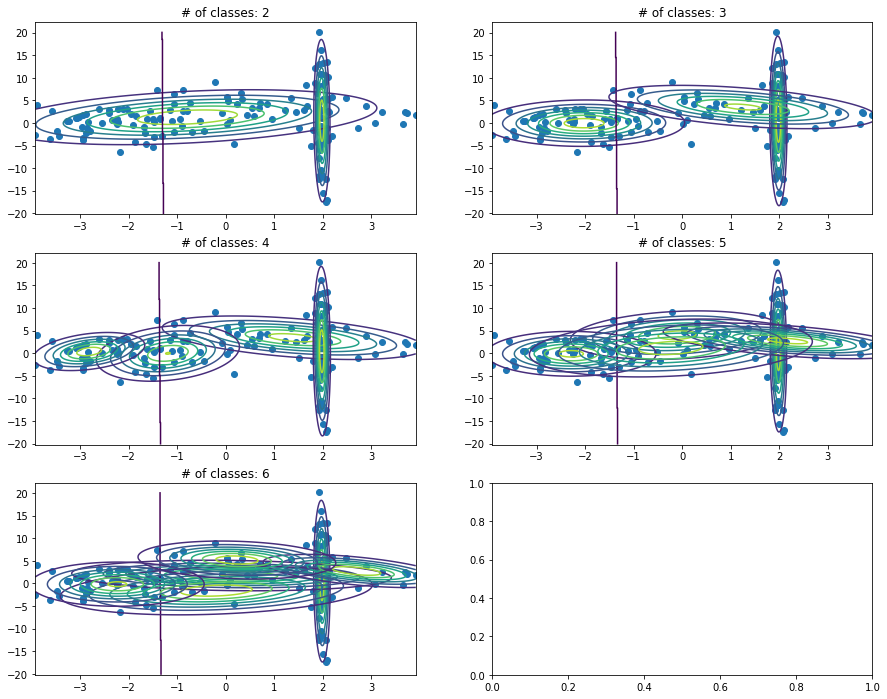

In [ ]:
# Let's plot the log likelihood trajectories and the final 2-d Clustering
plt.figure(figsize=(15,10))
for res, k in zip(results, Ks): 
    plt.plot(np.array(res[-1]), label=f'# of classes: {k}')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

x_max, y_max = np.max(np.abs(X[:,0])), np.max(np.abs(X[:,1]))
x, y = np.mgrid[-x_max:x_max:.01, -y_max:y_max:.01]
pos = np.dstack((x, y))

fig, axes = plt.subplots(3, 2, figsize=(15,12))
# Plot scatter plot of training data and corresponding clusters    
for (_, pi, means, covs, _), K, ax in zip(results, Ks, axes.reshape(-1,)): 
    for k in range(K):
        ax.contour(x, y, multivariate_normal(means[k], covs[k]).pdf(pos), )
    ax.scatter(X[0:,0], X[0:,1])
    ax.set_title(f'# of classes: {K}')

# MNIST clustering

Let's apply GMM to a slightly more complex dataset: MNIST (which we already encountered in the last homework).

In the following we shall use the sklearn implementation of the EM.

Once we fit the GMM we shall visualize the centers in order to evaluate whether the clustering algorithm came up with a meaningful solution (in an ideal scenario we would expect to have each center representing one single digit).

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.mixture import GaussianMixture
import sklearn

skver = sklearn.__version__.split('.')
if int(skver[1]) >= 24:
    X, Y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
else:
    X, Y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.

from sklearn.model_selection import train_test_split

m_t = 5000
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=m_t/len(Y), random_state=ID_number, 
                                                    stratify=Y)

# Function to plot a digit and print the corresponding label
def plot_digit(vect_img, ax, cluster_id=None):
    ax.set_title(f'Cluster ID: {cluster_id}')
    ax.imshow(
        vect_img.reshape(28,28),
        cmap          = 'gray',
        interpolation = "nearest"
    )

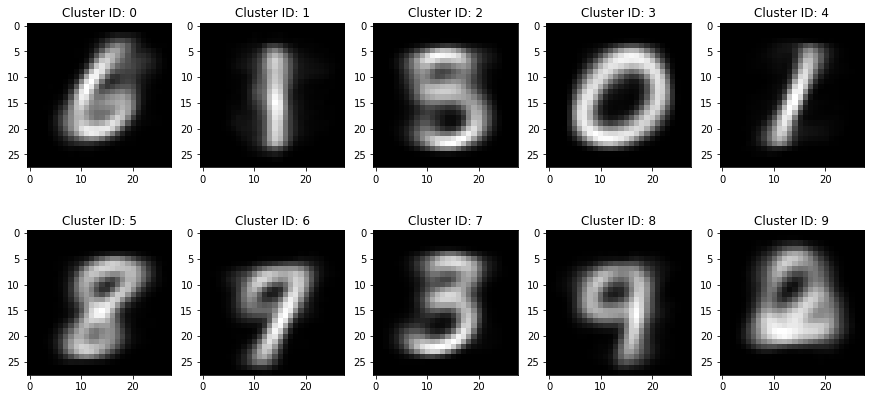

In [ ]:
# TODO 8: use GaussianMixture from skelearn to cluster x_train and then predict the labels.
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

K = 10
# When you initialize the GaussianMixture object use set random_state=ID_number
gmm = GaussianMixture(n_components = K, random_state=ID_number).fit(x_train)
gmm_pred = gmm.predict(x_train)
# YOUR CODE HERE

plt, axes = plt.subplots(2, K // 2, figsize=(15,7))
for k, ax in zip(range(K), axes.reshape(-1,)):
    plot_digit(gmm.means_[k], ax, cluster_id=k)   

In [ ]:
assert gmm_pred.shape == (m_t,)

# Comparison with supervised models: 
In the next cell we shall compare Unsupervised methods (Kmeans and GMM) with a
Supervised method (NNs) on MNIST. 
Note that supervised methods cannot be applied in the unsupervised setting (i.e. we do not have any label). 
Nonetheless we can apply an unsupervised method to a supervised problem (we just need to neglect the extra piece 
of information we have: the labels). 
In the following we shall train both Kmeans and GMM as if we do not have labels and then we shall compare their
predictions to the ground truth labels. 

NOTE: in an unsupervised scenario we are not able to compare model predictions with ground truth labels since 
labels are not part of the problem statement.

In [ ]:
# TODO 9: 
# Remember in ANY unsupervised clustering algorithm the name of the cluster DOES NOT possess any meaning. 
# The first class of the GMM model trained on the MNIST dataset does not necessarily represent the digits "0". 
# You can see this on the previous plots (plots of the centers of each component).
# Therefore we need to find a way to convert model clusters (predicitons) to ground truth labels. Several choices 
# are possible, in the following we shall use a very simple and straightforward rule: 
# 1- Find all the indeces of the data belonging to the same cluster predicted by the clustering model
# 2- Use these indeces (in the dataset) to gather the true labels
# 3- Compute the mode on the choosen true labels
# 4- Assign the mode as the new name of the cluster.
# In this way we are able to compare model predictions with the true labels (ground truth labels) and we can 
# compute the number of missclassified examples (as we did in previous Classification HWs). 

from scipy.stats import mode
def convert_prediction_labels(targets : np.ndarray, predictions : np.ndarray, num_clusters : int) -> np.ndarray:
    '''
    Function to assign a different label to the predictions of a clustering algorithm. Use the 4 steps described 
    earlier.
    :param targets: True labels (of shape (N,))
    :param predictions: Labels predicted by the clustering algorithm (of shape (N,))
    :param num_clusters: # of clusters in the training dataset
    :returns: 
        pred_labels: new labels for each datum (of shape (N,))
    '''
    targets = targets.to_numpy()
    pred_labels = np.zeros_like(targets)

    for k in range(num_clusters):
      index = np.where(predictions == k)
      aux = mode(targets[index])
      pred_labels[index] = aux[0]
        # YOUR CODE HERE

    return pred_labels

def compute_score(targets, predictions, num_clusters):
    pred_labels = convert_prediction_labels(targets, predictions, num_clusters)
    errors = sum(pred_labels == targets)
    return (1 - errors / len(targets))

In [ ]:
assert convert_prediction_labels(y_train, gmm_pred, 10).shape == (m_t,)


In [ ]:
a = np.array([[6, 8, 3, 0],
              [3, 2, 1, 7],
              [8, 1, 8, 4],
              [6, 3, 0, 5],
              [4, 7, 5, 9]])
from scipy import stats
stats.mode(a)

ModeResult(mode=array([[6, 1, 0, 0]]), count=array([[2, 1, 1, 1]]))

In [ ]:
print(np.shape(y_train))
print(y_train[0:10])


(5000,)
7562     6
44638    8
42451    7
32505    3
38830    5
44142    3
51950    5
12681    1
16272    7
68620    7
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']


In [ ]:
print(type(y_train))
y_train

<class 'pandas.core.series.Series'>


7562     6
44638    8
42451    7
32505    3
38830    5
        ..
49586    3
57912    0
41132    8
19671    1
60859    7
Name: class, Length: 5000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [ ]:
# TODO 10: Use sklearn GaussianMixture and KMeans to cluster x_train. Then evaluate the errors using the groud 
# truth labels (y_train) using the functions we built in the previous cell. Eventually we compare clustering 
# error rates with a supervised classification method: MLP.

# When you initialize the GaussianMixture and KMeans object use set random_state=ID_number
gmm = GaussianMixture(n_components = K, random_state=ID_number).fit(x_train)
gmm_pred_train, gmm_pred_test = gmm.predict(x_train), gmm.predict(x_test)
# YOUR CODE HERE
gmm_tr_err   = compute_score(y_train, gmm_pred_train, K)
gmm_test_err = compute_score(y_test, gmm_pred_test, K)
print(f'GMM Training err    {gmm_tr_err:.4f}, Test err {gmm_test_err:.4f}')


from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(x_train)
kmeans_pred_train, kmeans_pred_test = kmeans.predict(x_train), kmeans.predict(x_test)
# YOUR CODE HERE
kmeans_tr_err   = compute_score(y_train, kmeans_pred_train, K)
kmeans_test_err = compute_score(y_test, kmeans_pred_test, K)
print(f'Kmeans Training err {kmeans_tr_err:.4f}, Test err {kmeans_test_err:.4f}')


from sklearn.neural_network import MLPClassifier
best_mlp_large = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000, alpha=1e-4, solver='sgd', tol=1e-4, 
                               random_state=ID_number, learning_rate_init=.1)
best_mlp_large.fit(x_train, y_train)
training_error = 1. - best_mlp_large.score(x_train, y_train)
test_error = 1. - best_mlp_large.score(x_test, y_test)

print(f'MLP Training err    {training_error:.4f}, Test err {test_error:.4f}')

GMM Training err    0.4556, Test err 0.6129
Kmeans Training err 0.7924, Test err 0.7935
MLP Training err    0.0000, Test err 0.0629


In [ ]:
assert gmm_pred_train.shape == (m_t,)
assert gmm_pred_test.shape == (70000 - m_t,)
assert kmeans_pred_train.shape == (m_t,)
assert kmeans_pred_test.shape == (70000 - m_t,)

## TODO 11 (max 10 lines)

- What is the effect of a wrong choice of the number of clusters? Briefly describe both log-likelihood as a function of iterations and optimal clustering (depicted on the 2-D plot). 
- What does the 10 different plots in TODO 8 represent, with respect to the GMM approach?
- The number of errors using GMM on MNIST is quite high, could have you predicted such a behaviour looking only at the plots in TODO 8? Why?
- Compare GMM, Kmeans and NN. Which is the best model? Why? Did you expect the result?


(Answer in the next cell, no need to add code)

In [ ]:
# YOUR CODE HERE
"""
Choosing the correct number of clusters depends on the user objective of characterization/classification of the data, in relation to the similarities
of each of the data samples. Thus, a wrong selection of the number of cluster will output an undesised separation of the data. 
The log likelihood as a function of iterations when aproximating the predictions, will allow to get a proper likelihood, that other wise
in the case is not logarithmic, it will converge to not reliable likelihood. because of the probabilities being in the range of [0,1]

In the 10 images we see the representation of the samples classified, if the unsupervised algorithm was perfect we would see a clear image of each of the 
numbers, since we can see images where is not possible to recognize some numbers we can clearly tell that there are mismatches and confusion, which means
and not optimas clustering.

Comparing the results of the three algorithms is clear to conclude that neural networks achieve the less error, this would be expected since NN are
excelent function aproximators by nature, and its complexity and deepness can be easily increased to better fit data. Although its important to remark
that the nature of the NN in this case is of classification and the other 2 algorithms is of unsupervised.

"""


'\nChoosing the correct number of clusters depends on the user objective of characterization/classification of the data, in relation to the similarities\nof each of the data samples. Thus, a wrong selection of the number of cluster will output an undesised separation of the data. \nThe log likelihood as a function of iterations when aproximating the predictions, will allow to get a proper likelihood, that other wise\nin the case is not logarithmic, it will converge to not reliable likelihood. because of the probabilities being in the range of [0,1]\n\nIn the 10 images we see the representation of the samples classified, if the unsupervised algorithm was perfect we would see a clear image of each of the \nnumbers, since we can see images where is not possible to recognize some numbers we can clearly tell that there are mismatches and confusion, which means\nand not optimas clustering.\n\nComparing the results of the three algorithms is clear to conclude that neural networks achieve the 